# This notebook solves mesh recognition problem

In [1]:
import numpy as np
import random
import os
import glob

seed = 42
np.random.seed(seed)
random.seed(seed)

import keras
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, Input, Reshape
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras import initializers
from keras import callbacks
import keras.backend as K

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import matplotlib.pyplot as plt

K.clear_session()

F:\Anaconda\envs\py35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def count_files(dir, cat=''):
    wildcard = dir + os.sep + '**' + os.sep + '{}*.png'.format(cat)
    return len(glob.glob(wildcard, recursive=True))

dataset_path = 'Dataset_full_no_dublicates'
train_path = dataset_path + os.sep + 'train'
val_path = dataset_path + os.sep + 'validation'
test_path = dataset_path + os.sep + 'test'

batch_size = 30
train_batches_per_epoch = count_files(train_path) // batch_size + 1
val_batches_per_epoch = count_files(val_path) // batch_size + 1
num_epochs = 20
image_rows = 64
image_cols = 160

original_img_size = (image_rows, image_cols, 1)

classes = ['bed', 'chair', 'dresser', 'monitor', 'table', 'sofa', 'toilet']
num_classes = len(classes)
model_name = '{}_class'.format(num_classes)

use_saved_model = os.path.exists(model_name + '.h5')

In [3]:
def show_bars(y, labels):
    plt.figure(figsize=(20,10))
    plt.rc('xtick', labelsize=18)
    plt.rc('ytick', labelsize=18)
    plt.bar(range(len(y)), y, align='center')
    plt.xticks(range(len(labels)), labels)
    plt.show()


def show_weights(layer, root_n):
    layer_weights = layer.get_weights()[0][:,:,0,:]
    plt.xticks([])
    plt.yticks([])
    for i in range(1, root_n * root_n):
        plt.subplot(root_n, root_n, i)
        plt.imshow(layer_weights[:,:,i], interpolation="nearest", cmap="gray")
    plt.show()

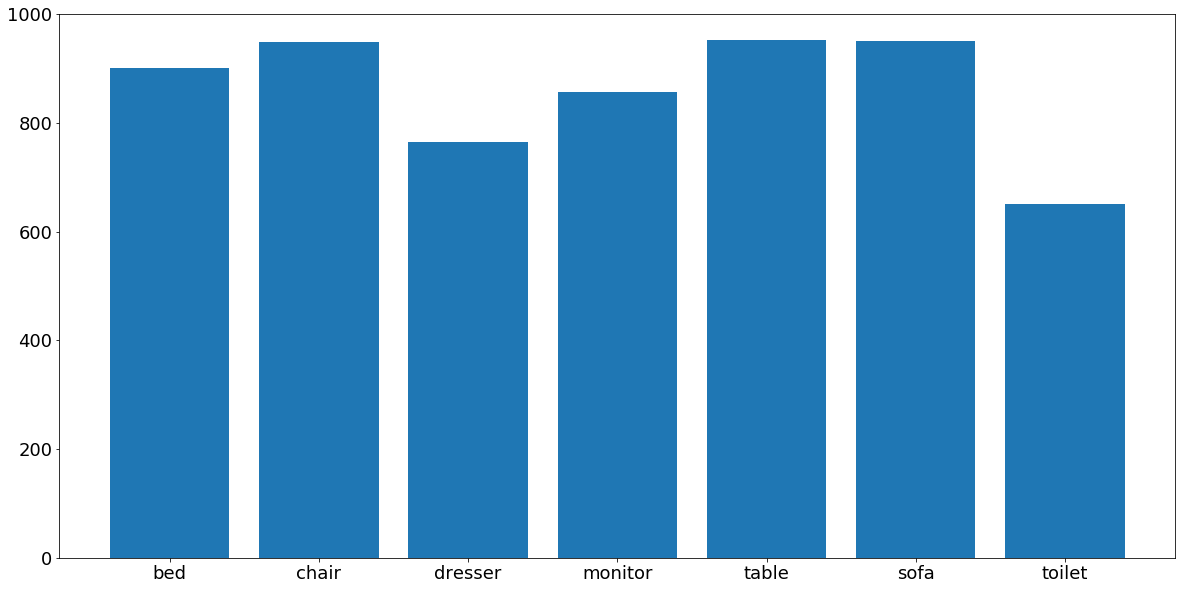

In [4]:
num_files = []
for i in range(len(classes)):
    num_files.append(count_files(dataset_path, classes[i]))

show_bars(num_files, classes)

In [5]:
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fbeta_score(y_true, y_pred, beta=1):
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')

    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score


def fmeasure(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=1)

## Model definition

In [6]:
def create_model():
    inp_1 = Input(shape=original_img_size)
    conv_1 = Conv2D(96, kernel_size=(5, 5),
                     activation='relu',
                     input_shape=(image_rows, image_cols, 1),
                     kernel_initializer=initializers.glorot_normal(seed),
                     bias_initializer=initializers.glorot_uniform(seed),
                     padding='same',
                     name='conv_1')(inp_1)
    batch_norm_1 = BatchNormalization()(conv_1)
    max_pool_1 = MaxPooling2D(pool_size=(2, 2), padding='same', name='max_pool1')(batch_norm_1)

    conv_2 = Conv2D(256, (5, 5), activation='relu',
                     kernel_initializer=initializers.glorot_normal(seed),
                     bias_initializer=initializers.glorot_uniform(seed),
                     padding='same', name='conv_2')(max_pool_1)
    batch_norm_2 = BatchNormalization()(conv_2)
    max_pool_2 = MaxPooling2D(pool_size=(2, 2), padding='same', name='max_pool2')(batch_norm_2)

    conv_3 = Conv2D(384, (3, 3), activation='relu',
                     kernel_initializer=initializers.glorot_normal(seed),
                     bias_initializer=initializers.glorot_uniform(seed),
                     padding='same', name='conv_3')(max_pool_2)

    batch_norm_3 = BatchNormalization()(conv_3)
    max_pool_3 = MaxPooling2D(pool_size=(2, 2), padding='same', name='max_pool_3')(batch_norm_3)
    rwmp = MaxPooling2D(pool_size=(1, 20), padding='same', name='rwmp')(max_pool_3)

    flatten_1 = Flatten(name='flatten1')(rwmp)
    dense_1 = Dense(64, activation='relu',
                    kernel_initializer='uniform',
                    bias_initializer='uniform',
                    name='dense_1')(flatten_1)
    dropout_1 = Dropout(0.5, name='dropout_1')(dense_1)
    dense_2 = Dense(64, activation='relu',
                    kernel_initializer='uniform',
                    bias_initializer='uniform',
                    name='dense_2')(dropout_1)
    dropout_2 = Dropout(0.5, name='dropout_2')(dense_2)
    softmax = Dense(num_classes, activation='softmax',
                    kernel_initializer='uniform',
                    bias_initializer='uniform',
                    name='output')(dropout_2)
    return Model(inp_1, softmax)

model = create_model()

optimizer = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=optimizer,
              metrics=[keras.metrics.categorical_accuracy, fmeasure, precision, recall])

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 160, 1)        0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 64, 160, 96)       2496      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 160, 96)       384       
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 32, 80, 96)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 32, 80, 256)       614656    
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 80, 256)       1024      
_________________________________________________________________
max_pool2 (MaxPooling2D)     (None, 16, 40, 256)       0         
__________

In [8]:
checkpointer = callbacks.ModelCheckpoint(model_name + '.h5',
                               monitor='val_categorical_accuracy',
                               save_best_only=True,
                               save_weights_only=False,
                               mode='max',
                               period=1)

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss',
                                        factor=0.5, patience=2,
                                        verbose=1, mode='auto',
                                        epsilon=0.0001,
                                        cooldown=0, min_lr=0)

tensorboard = callbacks.TensorBoard(log_dir='logs', histogram_freq=0, write_graph=True)

In [9]:
def read_data(directory):
    from PIL import Image
    
    def image_and_label(path):
        def encode_pattern(string):
            for i in range(len(classes)):
                if classes[i] in string:
                    return i
            raise ValueError('Unknown mesh category {}'.format(string))
        
        img = img_to_array(load_img(path, grayscale=True))
        label = encode_pattern(path)
    
        return img, label
    
    def images_and_labels(image_paths):
        images = []
        labels = []
        
        for path in image_paths:
            img, label = image_and_label(path)
            images.append(img)
            labels.append(label)
        
        labels = keras.utils.to_categorical(labels, num_classes=len(classes))
        return images, labels
    
    wildcard = directory + os.sep + '**' + os.sep + '*.png'
    image_paths = glob.glob(wildcard, recursive=True)
    
    images, labels = images_and_labels(image_paths)
    return np.array(images), labels

x_train, y_train = read_data(train_path)
x_val, y_val = read_data(val_path)

In [10]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

x_train, y_train = unison_shuffled_copies(x_train, y_train)
x_val, y_val = unison_shuffled_copies(x_val, y_val)

In [11]:
train_datagen = ImageDataGenerator(rescale=1.0/255.0)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_datagen.fit(x_train)
val_datagen.fit(x_val)

train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(x_val, y_val, batch_size=batch_size)

## Model training

In [12]:
%%time
history = model.fit_generator(
                    train_generator,
                    steps_per_epoch=train_batches_per_epoch,
                    epochs=num_epochs,
                    validation_data=val_generator,
                    validation_steps=val_batches_per_epoch,
                    callbacks=[checkpointer, reduce_lr, tensorboard],
                    workers=1,
                    use_multiprocessing=False,
                    shuffle=True)

Epoch 1/20
159/159 [==============================] - 1830s 12s/step - loss: 1.0620 - categorical_accuracy: 0.6103 - fmeasure: 0.5326 - precision: 0.7650 - recall: 0.4365 - val_loss: 0.6730 - val_categorical_accuracy: 0.7662 - val_fmeasure: 0.7599 - val_precision: 0.7952 - val_recall: 0.7297
Epoch 2/20
159/159 [==============================] - 1881s 12s/step - loss: 0.5906 - categorical_accuracy: 0.8111 - fmeasure: 0.7985 - precision: 0.8836 - recall: 0.7314 - val_loss: 0.6971 - val_categorical_accuracy: 0.7894 - val_fmeasure: 0.7891 - val_precision: 0.8394 - val_recall: 0.7463
Epoch 3/20
159/159 [==============================] - 1802s 11s/step - loss: 0.5005 - categorical_accuracy: 0.8368 - fmeasure: 0.8310 - precision: 0.8960 - recall: 0.7766 - val_loss: 0.6408 - val_categorical_accuracy: 0.7861 - val_fmeasure: 0.7849 - val_precision: 0.8292 - val_recall: 0.7463
Epoch 4/20
159/159 [==============================] - 1744s 11s/step - loss: 0.4404 - categorical_accuracy: 0.8529 - fmea

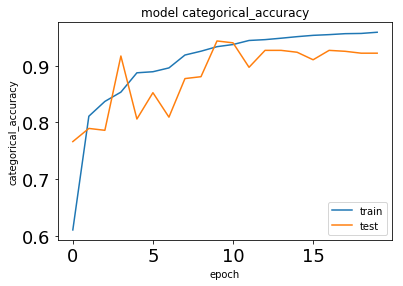

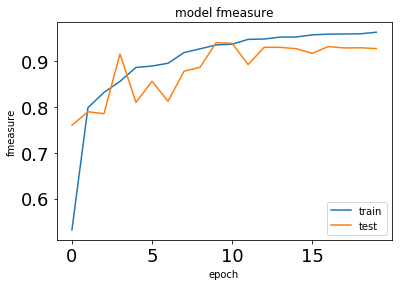

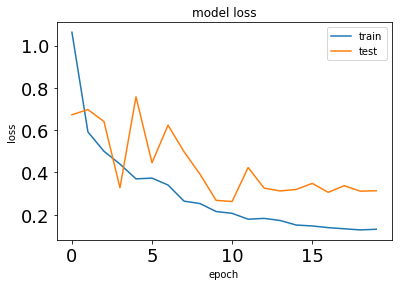

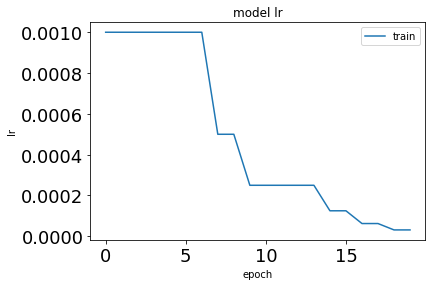

In [13]:
def show_history_for(name, plot_val=True):
    # summarize history for accuracy
    plt.plot(history.history[name])
    if plot_val:
        plt.plot(history.history['val_' + name])
    plt.title('model ' + name)
    plt.ylabel(name)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='best')
    plt.show()

show_history_for('categorical_accuracy')
show_history_for('fmeasure')
show_history_for('loss')
show_history_for('lr', plot_val=False)

## Loading checkpointed model

In [17]:
model = keras.models.load_model(model_name + '.h5', custom_objects={'fmeasure': fmeasure, 'precision': precision, 'recall': recall})

# Freeze model's weights from training during evaluation
for layer in model.layers:
    layer.trainable = False
    
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=optimizer,
              metrics=[keras.metrics.categorical_accuracy, fmeasure, precision, recall])

In [18]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 160, 1)        0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 64, 160, 96)       2496      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 160, 96)       384       
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 32, 80, 96)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 32, 80, 256)       614656    
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 80, 256)       1024      
_________________________________________________________________
max_pool2 (MaxPooling2D)     (None, 16, 40, 256)       0         
__________

## Collect true and predicted labels on test dataset 

In [20]:
x_test, test_true_labels = read_data(test_path)
x_test = x_test / 255.0
test_pred_labels = model.predict(x_test)

## Calculate a lot of different metrics

In [21]:
from sklearn import metrics

true_labels = np.argmax(test_true_labels, axis=1)
pred_labels = np.argmax(test_pred_labels, axis=1)

print(metrics.accuracy_score(true_labels, pred_labels))

def report(true_labels, pred_labels):
    print(metrics.classification_report(true_labels, pred_labels, target_names=classes))

report(true_labels, pred_labels)

0.8948948948948949
             precision    recall  f1-score   support

        bed       0.92      0.96      0.94       112
      chair       0.96      0.99      0.97        90
    dresser       0.65      0.95      0.77        80
    monitor       0.93      0.98      0.96       100
      table       0.94      0.68      0.79        92
       sofa       0.96      0.84      0.90        96
     toilet       0.98      0.84      0.91        96

avg / total       0.91      0.89      0.90       666



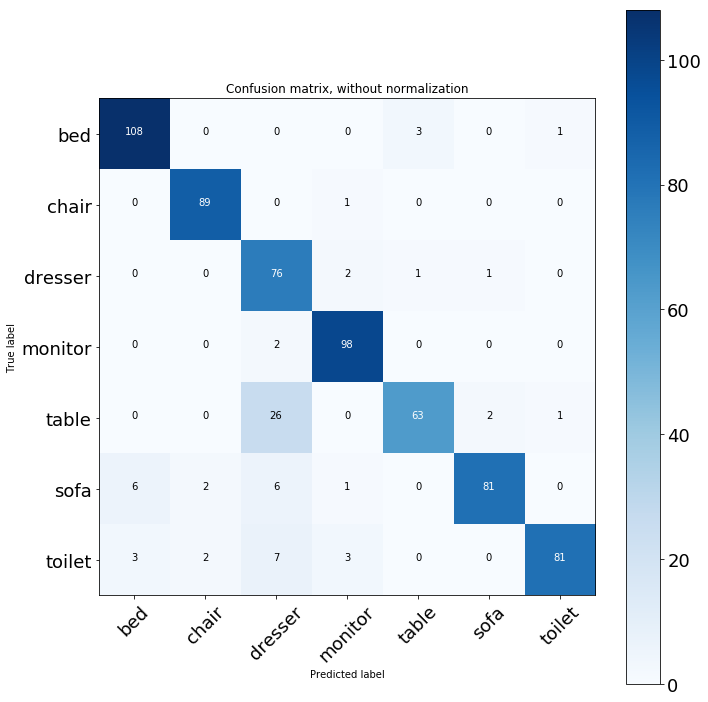

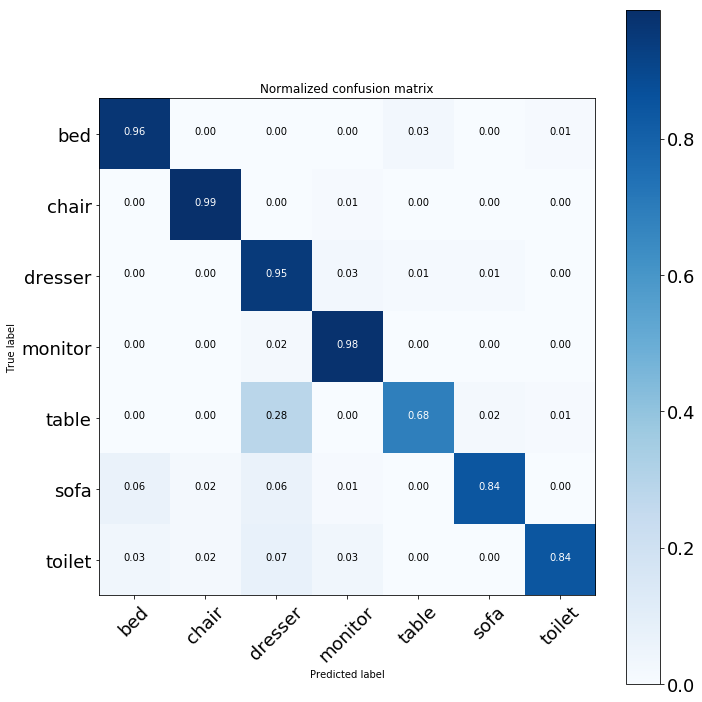

In [44]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Compute confusion matrix
cnf_matrix = confusion_matrix(np.argmax(test_true_labels, axis=1), np.argmax(test_pred_labels, axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=classes,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## Play around with the model

In [45]:
from scipy import misc
import trimesh

def what_is_this(filepath):
    img = img_to_array(load_img(filepath, grayscale=True))
    img = img / 255
    plt.imshow(img[:, :, 0], cmap='gray')
    plt.show()
    
    img = np.expand_dims(img, axis=0)
    
    probabilities = model.predict(img, batch_size=1, verbose=2)
    return classes[np.argmax(probabilities)], probabilities

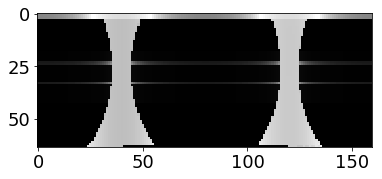

('table', array([[1.94e-13, 1.08e-10, 5.86e-12, 5.81e-15, 1.00e+00, 1.27e-31,
         5.15e-21]], dtype=float32))

In [46]:
what_is_this(test_path + os.sep + 'table' + os.sep + 'table_0224.png')

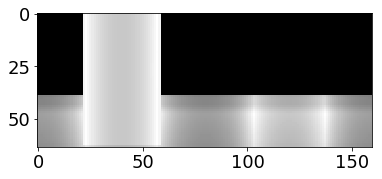

('bed', array([[9.81e-01, 5.44e-03, 5.83e-04, 3.50e-05, 1.06e-04, 1.41e-04,
         1.28e-02]], dtype=float32))

In [47]:
what_is_this(test_path + os.sep + 'bed' + os.sep + 'bed_0248.png')

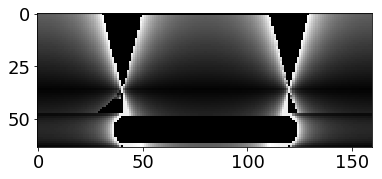

('monitor', array([[7.16e-08, 1.12e-06, 1.35e-04, 1.00e+00, 1.41e-04, 1.91e-07,
         5.69e-06]], dtype=float32))

In [48]:
what_is_this(test_path + os.sep + 'monitor' + os.sep + 'monitor_0249.png')

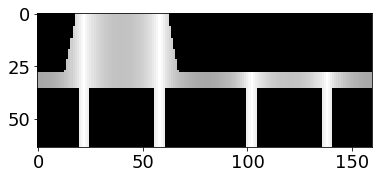

('chair', array([[8.70e-04, 9.99e-01, 3.66e-10, 1.78e-08, 8.93e-06, 2.73e-08,
         3.90e-08]], dtype=float32))

In [49]:
what_is_this(test_path + os.sep + 'chair' + os.sep + 'chair_0047.png')

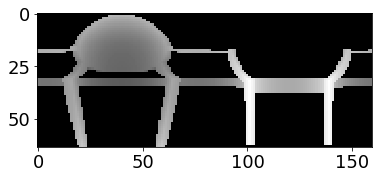

('chair', array([[8.57e-06, 1.00e+00, 3.37e-13, 1.06e-09, 2.01e-07, 4.79e-10,
         6.37e-10]], dtype=float32))

In [50]:
what_is_this(test_path + os.sep + 'chair' + os.sep + 'chair_0098.png')

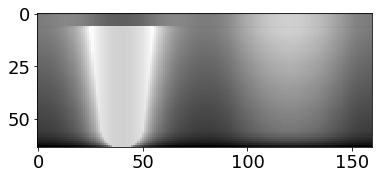

('dresser', array([[2.11e-04, 1.70e-05, 8.36e-01, 9.11e-02, 1.15e-02, 6.65e-04,
         6.01e-02]], dtype=float32))

In [51]:
what_is_this(test_path + os.sep + 'toilet' + os.sep + 'toilet_772.png')

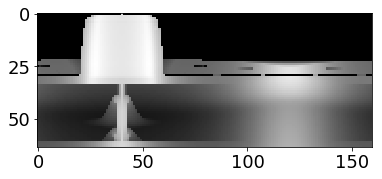

('toilet', array([[3.10e-04, 3.92e-04, 8.91e-05, 1.03e-04, 1.81e-05, 9.87e-06,
         9.99e-01]], dtype=float32))

In [52]:
what_is_this(test_path + os.sep + 'toilet' + os.sep + 'toilet_730.png')